# Load libs

In [1]:
import geopandas as gpd
from shapely.ops import unary_union
import pandas as pd
import pgeocode
import matplotlib as plt

# Manipulate shapes

## load communes

In [2]:
# Load the GeoJSON file
communes = gpd.read_file('data/communes4326.geojson')

In [3]:
communes.columns

Index(['COMMUNE', 'CANTON', 'DISTRICT', 'LAU2', 'geometry'], dtype='object')

## make cantons

In [4]:
# Group by 'CANTON' and merge the polygons
cantons = communes.dissolve(by='CANTON', aggfunc='sum')

In [5]:
# Save the result to a new GeoJSON file
cantons.to_file('data/cantons.geojson', driver='GeoJSON')

In [8]:
# Add a column named 'CANTON' and apply the name of each canton
cantons['CANTON'] = cantons.index
cantons.columns

Index(['geometry', 'COMMUNE', 'DISTRICT', 'LAU2', 'CANTON'], dtype='object')

## districts

In [9]:
# Group by 'DISTRICT' and merge the polygons
districts = communes.dissolve(by='DISTRICT', aggfunc='sum')

In [10]:
# Save the result to a new GeoJSON file
districts.to_file('data/district.geojson', driver='GeoJSON')

## country

In [11]:
# Merge all the polygons in communes to create a single polygon for the country
country = gpd.GeoDataFrame(geometry=[unary_union(communes.geometry)], crs=communes.crs)

In [12]:
# Save the result to a new GeoJSON file
country.to_file('data/lux.geojson', driver='GeoJSON')

# Load density

In [13]:
density = gpd.read_file("data/Densite_de_population_communes_lux/Densité de population communes lux.shp")

In [14]:
density.columns

Index(['COMMUNE', 'CANTON', 'DISTRICT', 'LAU2', 'Longitude', 'Latitude',
       'Densité de', 'geometry'],
      dtype='object')

In [45]:
density.to_file('data/lux_pop_density.geojson')

## plot density

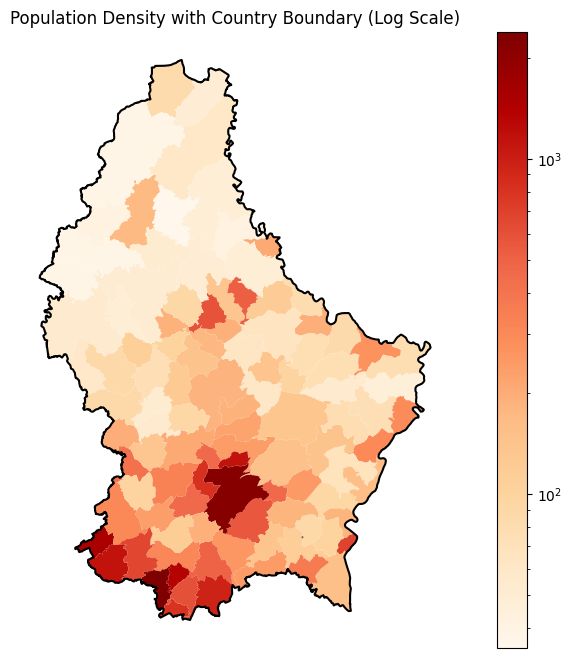

In [15]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

# Reproject the density GeoDataFrame to the same CRS as the country GeoDataFrame
density = density.to_crs(country.crs)

# Plot the density layer
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the density layer with 50% transparency and color by "Densité de" column using log scale
density.plot(ax=ax, column='Densité de', cmap='OrRd', alpha=1, legend=True, norm=LogNorm())

# Overlay country boundary in bold black
country.boundary.plot(ax=ax, color='black', linewidth=1.5)

plt.title("Population Density with Country Boundary (Log Scale)")
plt.axis("off")
plt.show()

C:\Users\adhav\AppData\Local\Temp\ipykernel_15288\1054788040.py:19: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if row.geometry.type == 'Polygon':


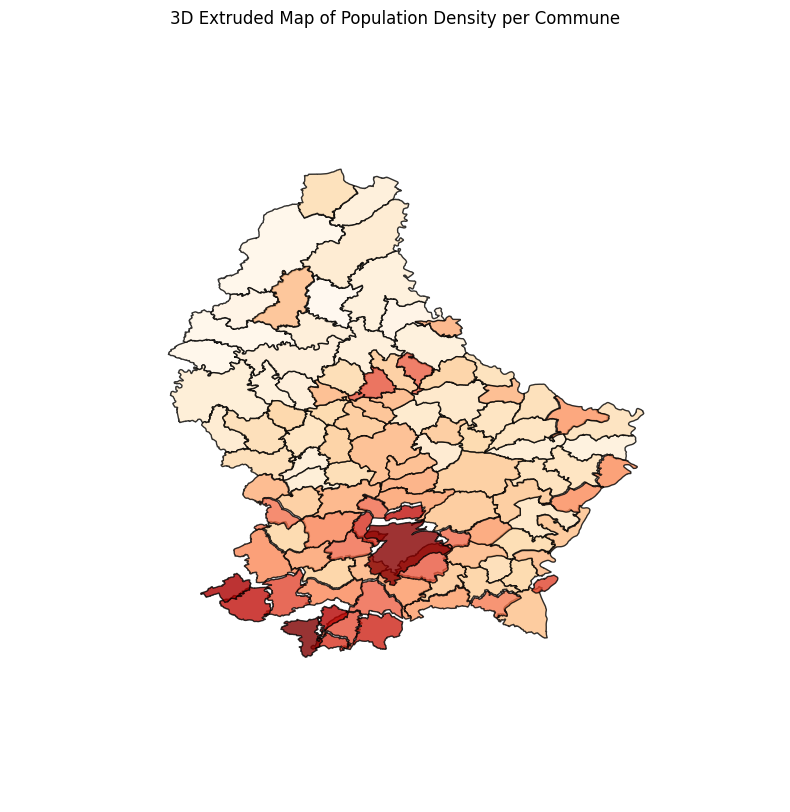

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from matplotlib.colors import LogNorm

# Ensure CRS is consistent
density = density.to_crs(country.crs)

# Create 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Scaling factor for height (tweak this!)
height_scale = 0.1  

# Loop through each commune polygon and extrude by density
for idx, row in density.iterrows():
    if row.geometry.type == 'Polygon':
        geoms = [row.geometry]
    else:
        geoms = row.geometry.geoms

    for geom in geoms:
        x, y = geom.exterior.xy
        z = np.zeros(len(x))
        height = row['Densité de'] * height_scale
        verts = [list(zip(x, y, z + height))]  # "lift" the polygon
        poly = Poly3DCollection(verts, alpha=0.8)
        poly.set_facecolor(plt.cm.OrRd(LogNorm(vmin=density['Densité de'].min(), vmax=density['Densité de'].max())(row['Densité de'])))
        poly.set_edgecolor('k')
        ax.add_collection3d(poly)

# Set limits based on the data bounds
xmin, ymin, xmax, ymax = density.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_zlim(0, density['Densité de'].max() * height_scale)

ax.set_title('3D Extruded Map of Population Density per Commune')
ax.axis('off')

# Set view angle (optional)
ax.view_init(elev=90, azim=270)
plt.show()


# WWTP

In [17]:
# 1. Load the communes geoJSON
communes = gpd.read_file("./data/luxembourg-communes.geojson")

In [18]:
# 2. Load your Excel file with WWTP and Locality columns
mapping = pd.read_csv("data/Code_postal_par_STEP_merged 20230517.csv")

In [19]:
# 3. Merge: join communes and mapping on Locality name
# Make sure the column names match. For instance:
# In geojson: communes['locality'] or communes['name']
# In Excel: mapping['Locality']
communes['name'] = communes['name'].str.lower().str.strip()
mapping['Locality'] = mapping['Locality'].str.lower().str.strip()

In [20]:
# 4. Merge using the 'name' field from communes and 'Locality' from mapping
merged = communes.merge(mapping, left_on="name", right_on="Locality", how="inner")

In [21]:
# 5. Dissolve by WWTP to merge all polygons of each WWTP into one shape
dissolved = merged.dissolve(by="WWTP", as_index=False)

In [22]:
# 6. Save output to GeoJSON
dissolved.to_file("./data/wwtp_catchments.geojson", driver="GeoJSON")

print("✅ Done! The WWTP catchment areas GeoJSON has been created.")

✅ Done! The WWTP catchment areas GeoJSON has been created.


In [23]:
# Load country boundary GeoJSON
country = gpd.read_file("data/lux.geojson")

## plot the catchment areas of the WWTP

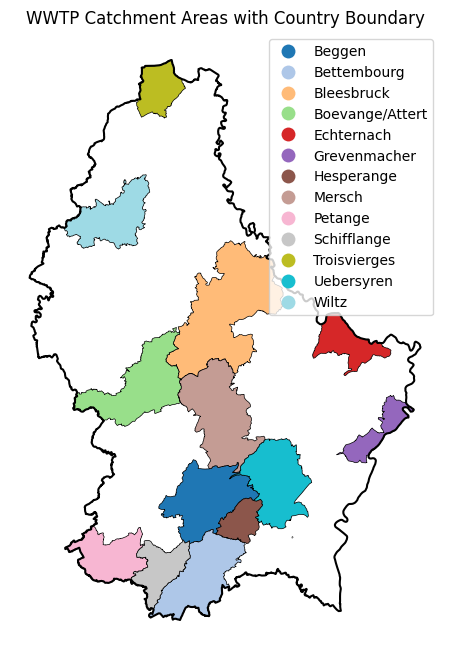

In [24]:
import matplotlib.pyplot as plt

# Plot both
fig, ax = plt.subplots(figsize=(12, 8))

# Plot WWTP catchments in color
dissolved.plot(ax=ax, column='WWTP', cmap='tab20', legend=True, edgecolor='black', linewidth=0.5)

# Overlay country boundary in bold black
country.boundary.plot(ax=ax, color='black', linewidth=1.5)

plt.title("WWTP Catchment Areas with Country Boundary")
plt.axis("off")

# Save the plot to a file
# plt.savefig('./images/WWTP_catchment_areas.png', dpi=300)

plt.show()

### plot zip code

for certififcate issue

In [25]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [26]:
# Load CSV with WWTP and zip codes
zip_data = pd.read_csv("data/Code_postal_par_STEP_merged 20230517.csv")

In [27]:
# Initialize pgeocode for Luxembourg (country code = 'LU')
nomi = pgeocode.Nominatim('LU')

In [28]:
# Get coordinates for each unique postal code
unique_zips = zip_data['Code postal'].unique()

In [29]:
# Load the geojson and the CSV
addresses = gpd.read_file('./data/addresses.geojson')

In [30]:
mapping['Code postal'] = mapping['Code postal'].astype(str)

In [31]:
# Create an empty list to store the coordinates
zip_coordinates = []

# Iterate over unique zip codes in the CSV
for zip_code in mapping['Code postal'].unique():
    # Find the address in the geojson file matching the zip code
    matched_address = addresses[addresses['code_postal'] == zip_code]
    
    if not matched_address.empty:
        # Get the coordinates (longitude, latitude) for the first matched address
        coordinates = matched_address.geometry.iloc[0].coords
        longitude, latitude = list(coordinates)[0]
        
        # Append the result to the list
        zip_coordinates.append({
            'postal_code': zip_code,
            'latitude': latitude,
            'longitude': longitude
        })

# Convert to DataFrame
zip_coordinates_df = pd.DataFrame(zip_coordinates)


In [32]:
print(addresses.columns)

Index(['rue', 'numero', 'localite', 'code_postal', 'id_caclr_rue',
       'id_caclr_bat', 'id_geoportail', 'commune', 'lau2', 'geometry'],
      dtype='object')


## Plot the zip codes and catchment areas of WWTP

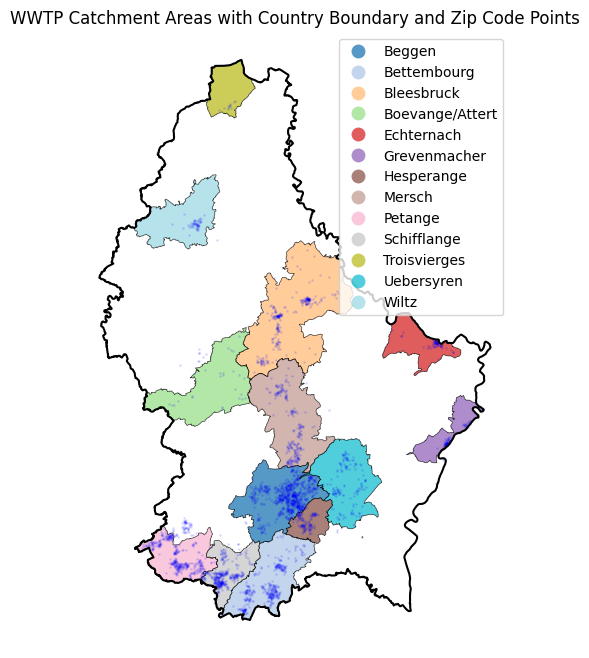

In [33]:
# Plot both
fig, ax = plt.subplots(figsize=(12, 8))

# Plot WWTP catchments in color
dissolved.plot(ax=ax, column='WWTP', cmap='tab20', alpha=0.75, legend=True, edgecolor='black', linewidth=0.5)

# Overlay country boundary in bold black
country.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Plot the zip code points (from the coordinates DataFrame)
zip_points = gpd.GeoDataFrame(
    zip_coordinates_df, 
    geometry=gpd.points_from_xy(zip_coordinates_df.longitude, zip_coordinates_df.latitude),
    crs="EPSG:4326"
)

# Plot the points
zip_points.plot(ax=ax, color='blue', markersize=1, alpha=0.1, label='Zip Code Points')

# Add a legend and title
# plt.legend()
plt.title("WWTP Catchment Areas with Country Boundary and Zip Code Points")
plt.axis("off")

# Save the plot to a file
plt.savefig('./images/WWTP_catchment_areas_w_zip.png', dpi=300)

# Save the figure in a variable
plot_top_left_w_zip_wwtp_orig = fig

plt.show()


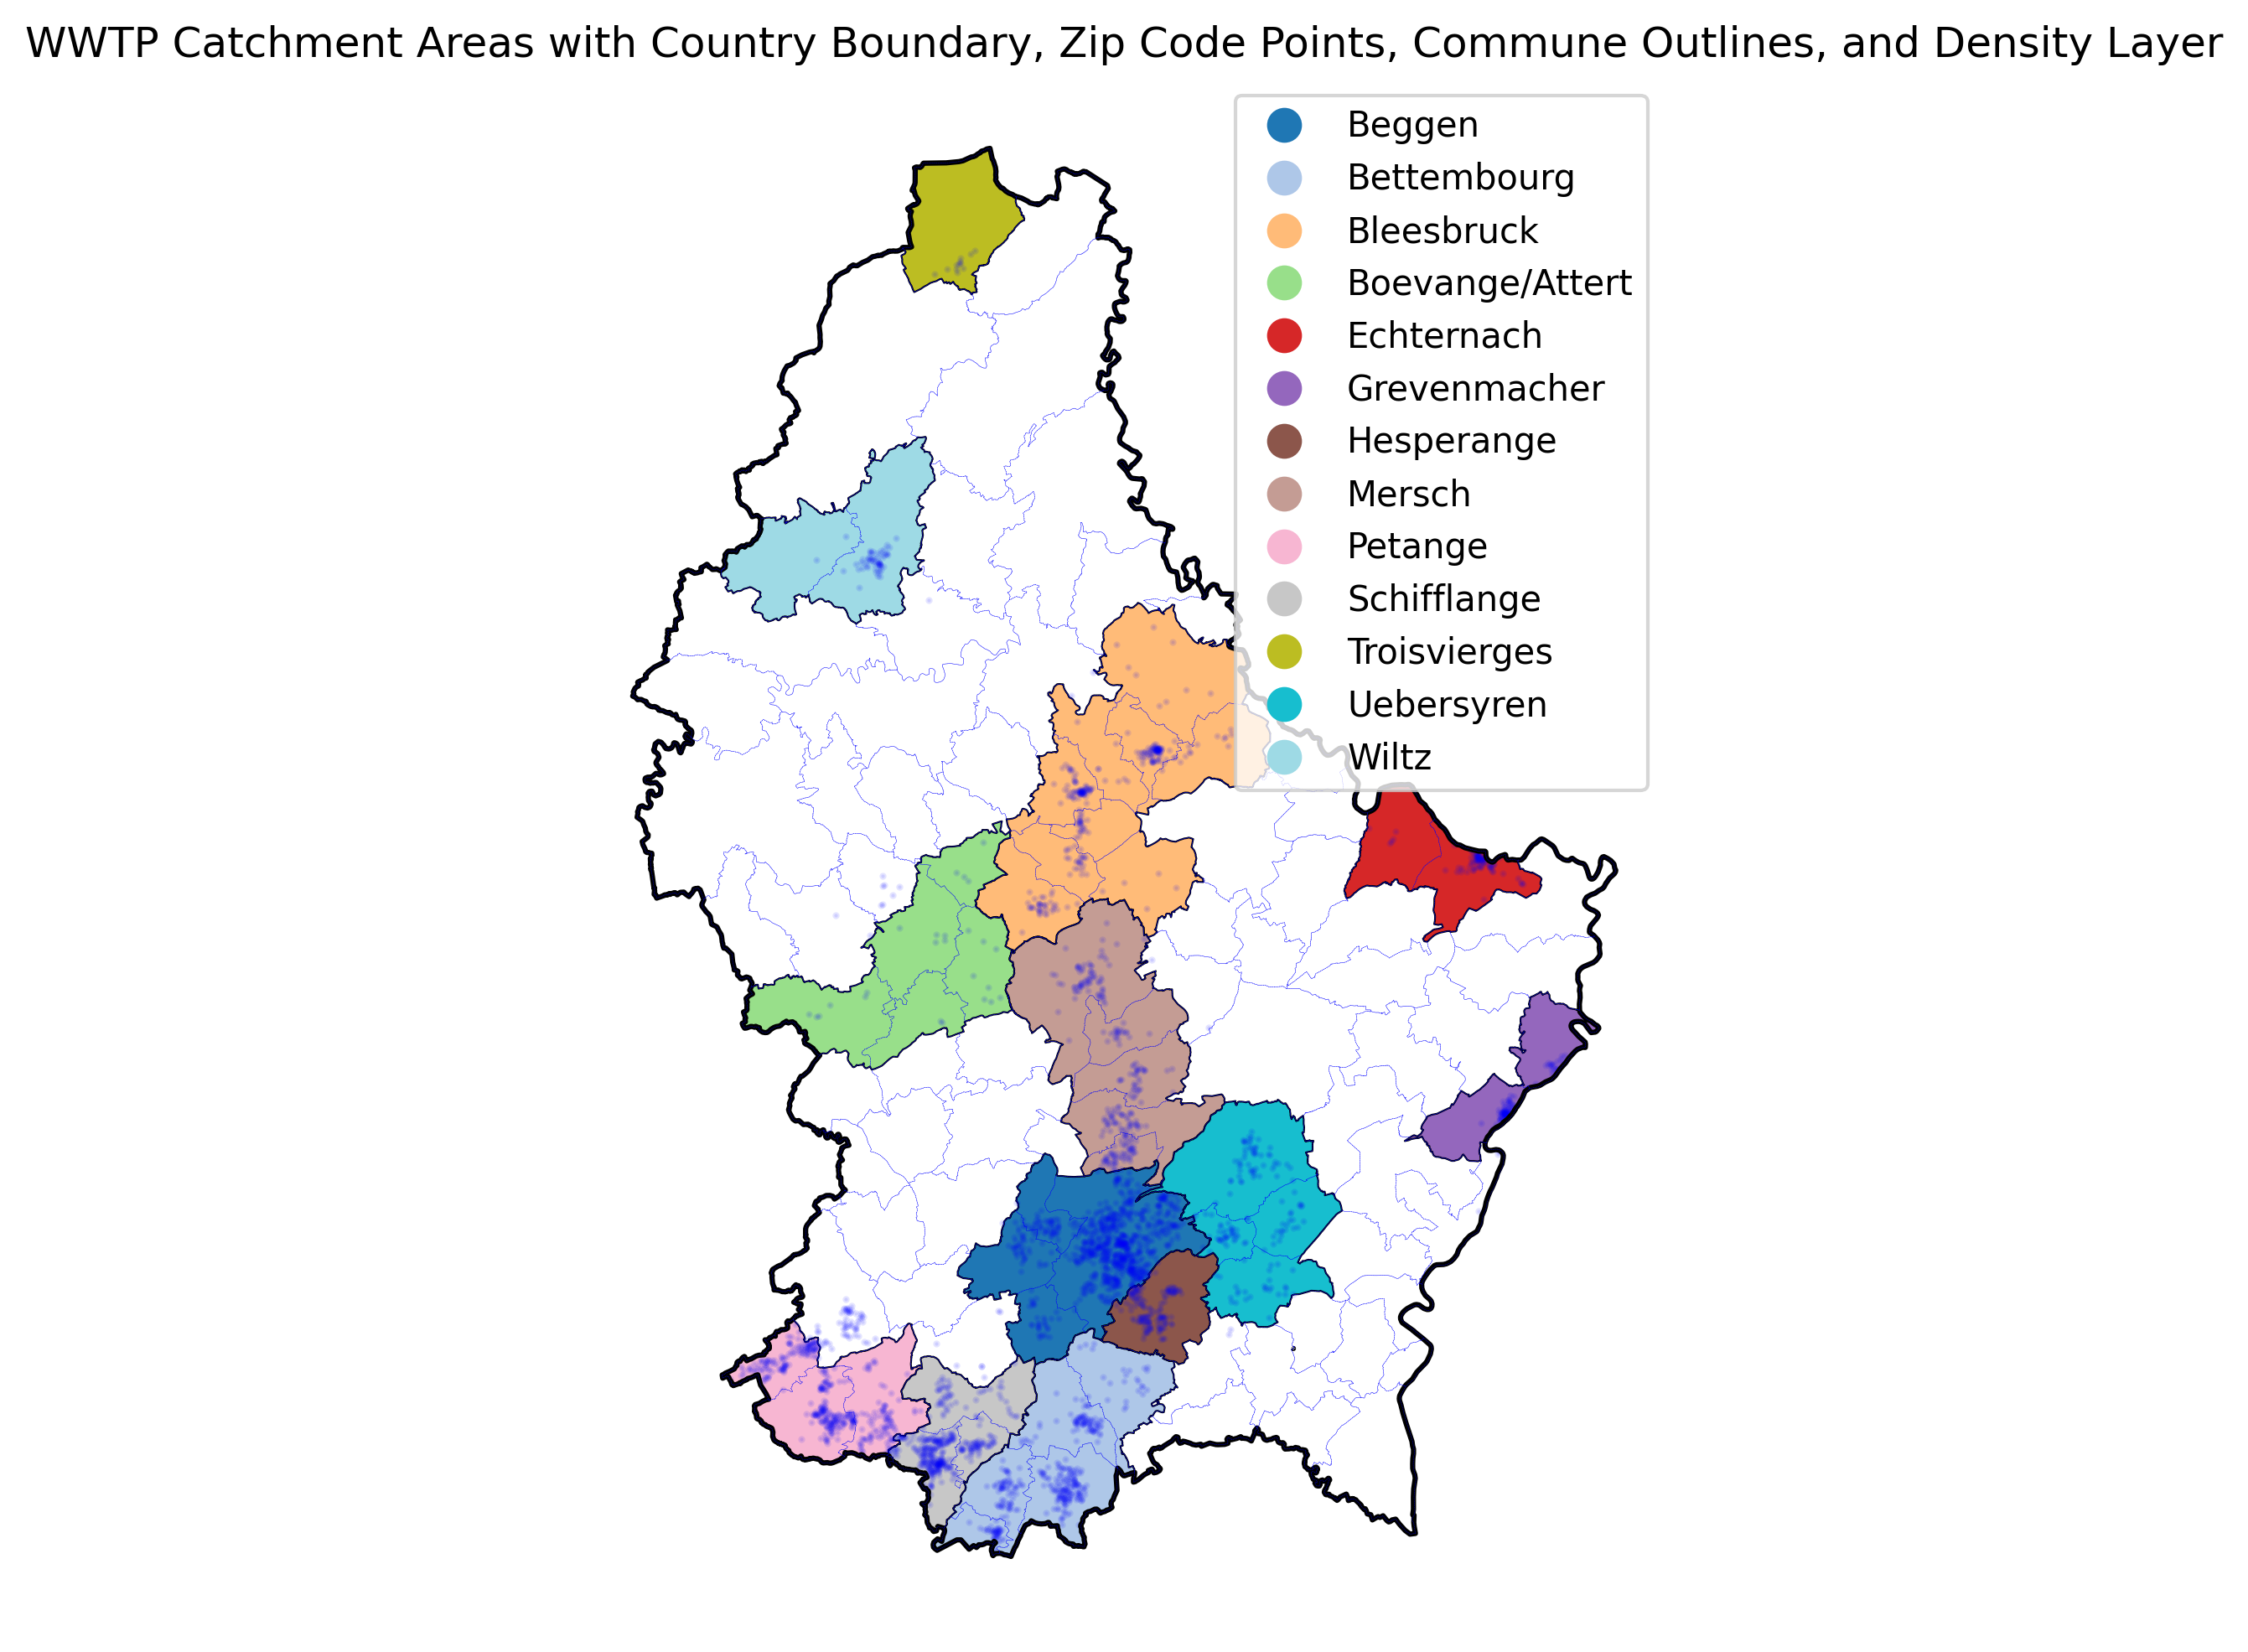

In [34]:
# Plot both
fig, ax = plt.subplots(figsize=(12, 8))

# Plot WWTP catchments in color
dissolved.plot(ax=ax, column='WWTP', cmap='tab20', legend=True, edgecolor='black', linewidth=0.5)

# Overlay country boundary in bold black
country.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Plot the zip code points (from the coordinates DataFrame)
zip_points = gpd.GeoDataFrame(
    zip_coordinates_df, 
    geometry=gpd.points_from_xy(zip_coordinates_df.longitude, zip_coordinates_df.latitude),
    crs="EPSG:4326"
)

# Plot the points
zip_points.plot(ax=ax, color='blue', markersize=1, alpha=0.1, label='Zip Code Points')

# Plot the commune shapes outlines where the zip points fall
communes.boundary.plot(ax=ax, color='blue', linewidth=0.1, linestyle='--')

# Add a legend and title
# plt.legend()
plt.title("WWTP Catchment Areas with Country Boundary, Zip Code Points, Commune Outlines, and Density Layer")
plt.axis("off")
plt.gcf().set_dpi(300)

# Save the plot to a file
plt.savefig('./images/WWTP_catchment_areas_w_zip_w_communes.png', dpi=300)

plt.show()


# Merge missing communes

- Préizerdaul, Boevange/Attert
- Redange, Boevange/Attert
- Goesdorf, Wiltz
- Weiler-la-Tour, Hesperange
- Larochette, Mersch
- Fischbach, Mersch
- Junglinster, Mersch
- Wormeldange, Grevenmacher
- Beaufort, Echternach
- Bourscheid, Bleesbruck
- Käerjeng, Petange
- Reckange-sur-Mess, Beggen

In [35]:
# List of additional mappings
additional_mappings = [
    {"Commune": "Préizerdaul", "WWTP": "Boevange/Attert"},
    {"Commune": "Redange", "WWTP": "Boevange/Attert"},
    {"Commune": "Goesdorf", "WWTP": "Wiltz"},
    {"Commune": "Weiler-la-Tour", "WWTP": "Hesperange"},
    {"Commune": "Larochette", "WWTP": "Mersch"},
    {"Commune": "Fischbach", "WWTP": "Mersch"},
    {"Commune": "Junglinster", "WWTP": "Mersch"},
    {"Commune": "Wormeldange", "WWTP": "Grevenmacher"},
    {"Commune": "Beaufort", "WWTP": "Echternach"},
    {"Commune": "Bourscheid", "WWTP": "Bleesbruck"},
    {"Commune": "Käerjeng", "WWTP": "Petange"},
    {"Commune": "Reckange-sur-Mess", "WWTP": "Beggen"}
]

# Convert the list to a DataFrame
additional_mappings_df = pd.DataFrame(additional_mappings)

# Standardize the commune names to match the existing format
additional_mappings_df['Commune'] = additional_mappings_df['Commune'].str.lower().str.strip()

# Merge the additional mappings with the existing mapping DataFrame
mapping_mod = pd.concat([mapping, additional_mappings_df.rename(columns={"Commune": "Locality"})], ignore_index=True)

# Merge using the 'name' field from communes and 'Locality' from mapping
merged_mod = communes.merge(mapping_mod, left_on="name", right_on="Locality", how="inner")

# Dissolve by WWTP to merge all polygons of each WWTP into one shape
dissolved_mod = merged_mod.dissolve(by="WWTP", as_index=False)

# Save output to GeoJSON
dissolved_mod.to_file("./data/wwtp_catchments_updated.geojson", driver="GeoJSON")

print("✅ Done! The updated WWTP catchment areas GeoJSON has been created.")

✅ Done! The updated WWTP catchment areas GeoJSON has been created.


## plot adjusted catchment areas for WWTP

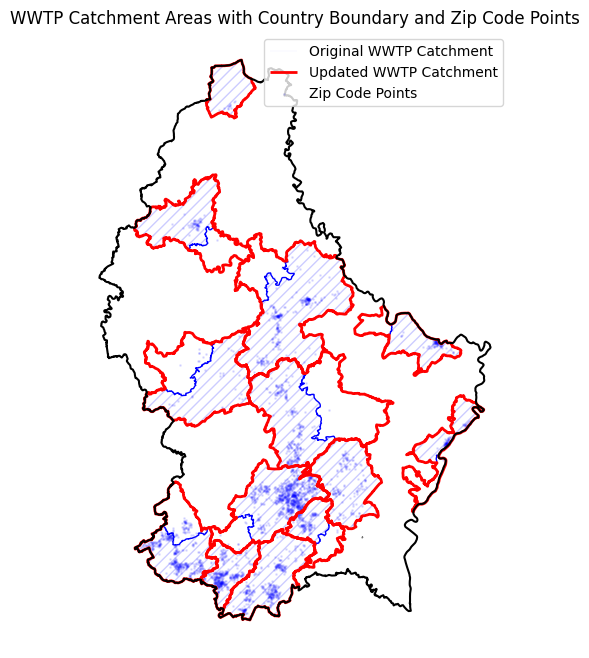

In [36]:
# Plot both
fig, ax = plt.subplots(figsize=(12, 8))

# Plot WWTP catchments in color
dissolved.boundary.plot(ax=ax, cmap='tab20', hatch='///', color='blue', alpha=0.2, linewidth=0.1, label='Original WWTP Catchment')
dissolved.boundary.plot(ax=ax, cmap='tab20', color='blue', alpha=1, linewidth=1)

dissolved_mod.boundary.plot(ax=ax, cmap='tab20', color='red', alpha=1, linewidth=2, label='Updated WWTP Catchment')

# Overlay country boundary in bold black
country.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Plot the zip code points (from the coordinates DataFrame)
zip_points = gpd.GeoDataFrame(
    zip_coordinates_df, 
    geometry=gpd.points_from_xy(zip_coordinates_df.longitude, zip_coordinates_df.latitude),
    crs="EPSG:4326"
)

# Plot the points
zip_points.plot(ax=ax, color='blue', markersize=1, alpha=0.1, label='Zip Code Points')

# Add a legend and title
plt.legend()
plt.title("WWTP Catchment Areas with Country Boundary and Zip Code Points")
plt.axis("off")

# Save the plot to a file
plt.savefig('./images/WWTP_catchment_areas_compared.png', dpi=300)

# Save the figure in a variable
plot_bottom_left_w_zip_wwtp_mod = fig

plt.show()


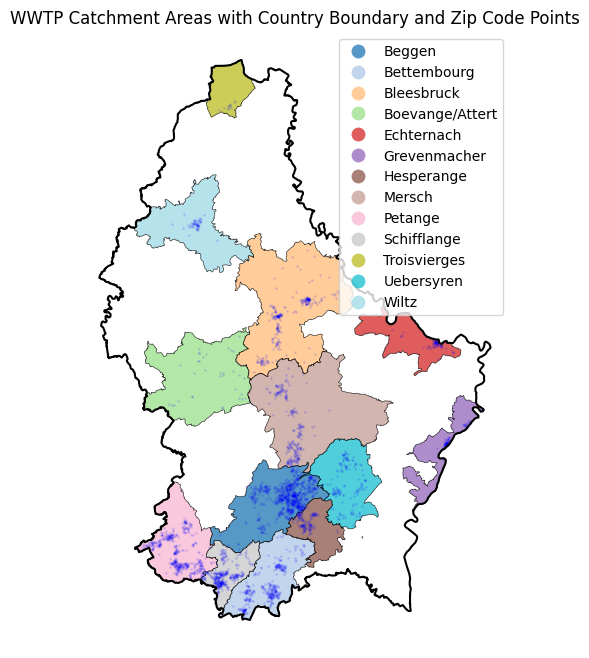

In [37]:
# Plot both
fig, ax = plt.subplots(figsize=(12, 8))

# Plot WWTP catchments in color
# dissolved.boundary.plot(ax=ax, cmap='tab20', hatch='///', color='blue', alpha=0.2, linewidth=0.1)
# dissolved.boundary.plot(ax=ax, cmap='tab20', color='blue', alpha=1, linewidth=1)

dissolved_mod.plot(ax=ax, column='WWTP', cmap='tab20', alpha=0.75, legend=True, edgecolor='black', linewidth=0.5)

# Overlay country boundary in bold black
country.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Plot the zip code points (from the coordinates DataFrame)
zip_points = gpd.GeoDataFrame(
    zip_coordinates_df, 
    geometry=gpd.points_from_xy(zip_coordinates_df.longitude, zip_coordinates_df.latitude),
    crs="EPSG:4326"
)

# Plot the points
zip_points.plot(ax=ax, color='blue', markersize=1, alpha=0.1, label='Zip Code Points')

# Add a legend and title
# plt.legend()
plt.title("WWTP Catchment Areas with Country Boundary and Zip Code Points")
plt.axis("off")

# Save the plot to a file
plt.savefig('./images/WWTP_catchment_areas_modified_w_zip.png', dpi=300)

# Save the figure in a variable
plot_bottom_left_w_zip_wwtp_mod = fig

plt.show()


## plot density

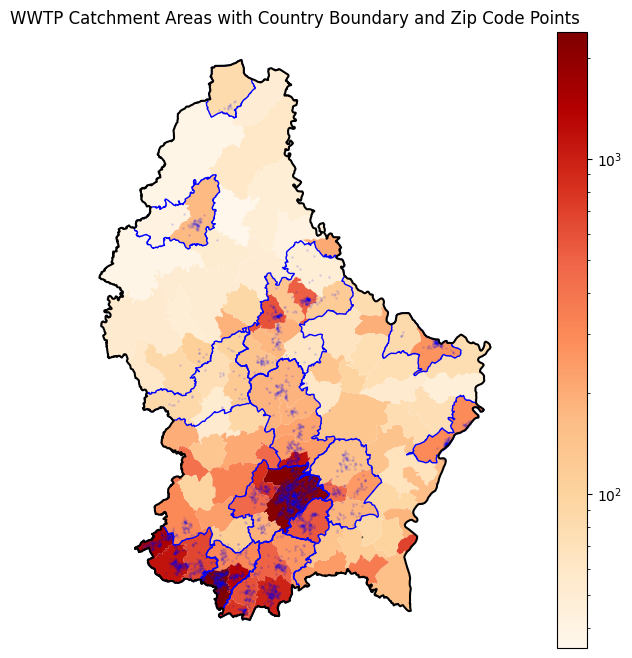

In [38]:
# Plot both
fig, ax = plt.subplots(figsize=(12, 8))


density.plot(ax=ax, column='Densité de', cmap='OrRd', alpha=1, legend=True, norm=LogNorm())

# Plot WWTP catchments in color
dissolved.boundary.plot(ax=ax, cmap='tab20', color='blue', alpha=1, linewidth=1)

# Overlay country boundary in bold black
country.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Plot the zip code points (from the coordinates DataFrame)
zip_points = gpd.GeoDataFrame(
    zip_coordinates_df, 
    geometry=gpd.points_from_xy(zip_coordinates_df.longitude, zip_coordinates_df.latitude),
    crs="EPSG:4326"
)

# Plot the points
zip_points.plot(ax=ax, color='blue', markersize=1, alpha=0.1, label='Zip Code Points')

# Add a legend and title
# plt.legend()
plt.title("WWTP Catchment Areas with Country Boundary and Zip Code Points")
plt.axis("off")

plt.show()


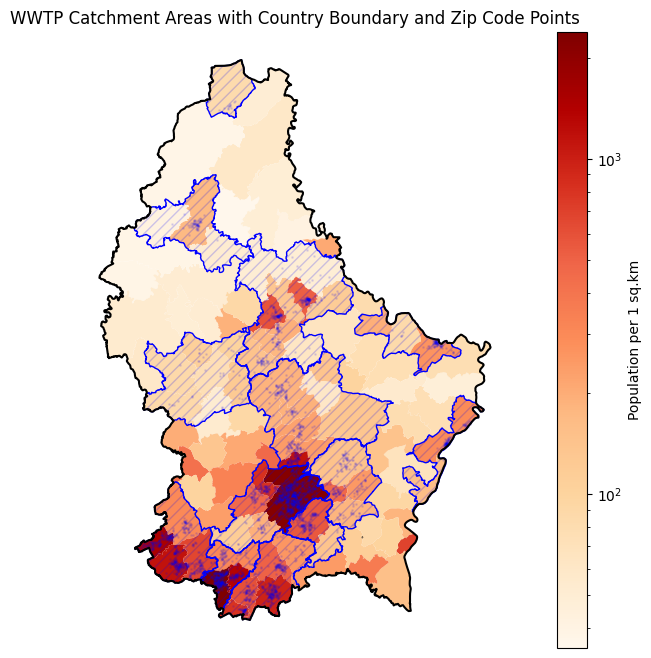

In [39]:
# Plot both
fig, ax = plt.subplots(figsize=(12, 8))


density.plot(ax=ax, column='Densité de', cmap='OrRd', alpha=1, legend=True, norm=LogNorm(), 
             legend_kwds={'label': "Population per 1 sq.km"})

# Plot WWTP catchments in color
dissolved_mod.boundary.plot(ax=ax, cmap='tab20', hatch='///', color='blue', alpha=0.2, linewidth=0.1)
dissolved_mod.boundary.plot(ax=ax, cmap='tab20', color='blue', alpha=1, linewidth=1)

# Identify areas not in dissolved and plot them with hatch style
# not_in_dissolved = communes[~communes.index.isin(dissolved.index)]
# not_in_dissolved.boundary.plot(ax=ax, hatch='///', edgecolor='red', linewidth=0.5)

# Overlay country boundary in bold black
country.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Plot the zip code points (from the coordinates DataFrame)
zip_points = gpd.GeoDataFrame(
    zip_coordinates_df, 
    geometry=gpd.points_from_xy(zip_coordinates_df.longitude, zip_coordinates_df.latitude),
    crs="EPSG:4326"
)

# Plot the points
zip_points.plot(ax=ax, color='blue', markersize=1, alpha=0.1, label='Zip Code Points')

# Add a legend and title
# plt.legend()
plt.title("WWTP Catchment Areas with Country Boundary and Zip Code Points")
plt.axis("off")

# Save the plot to a file
plt.savefig('./images/WWTP_catchment_areas_modified_w_zip_w_density.png', dpi=300)

# Save the figure in a variable
plot_bottom_left_w_zip_wwtp_mod_w_density = fig

plt.show()


## merge plots

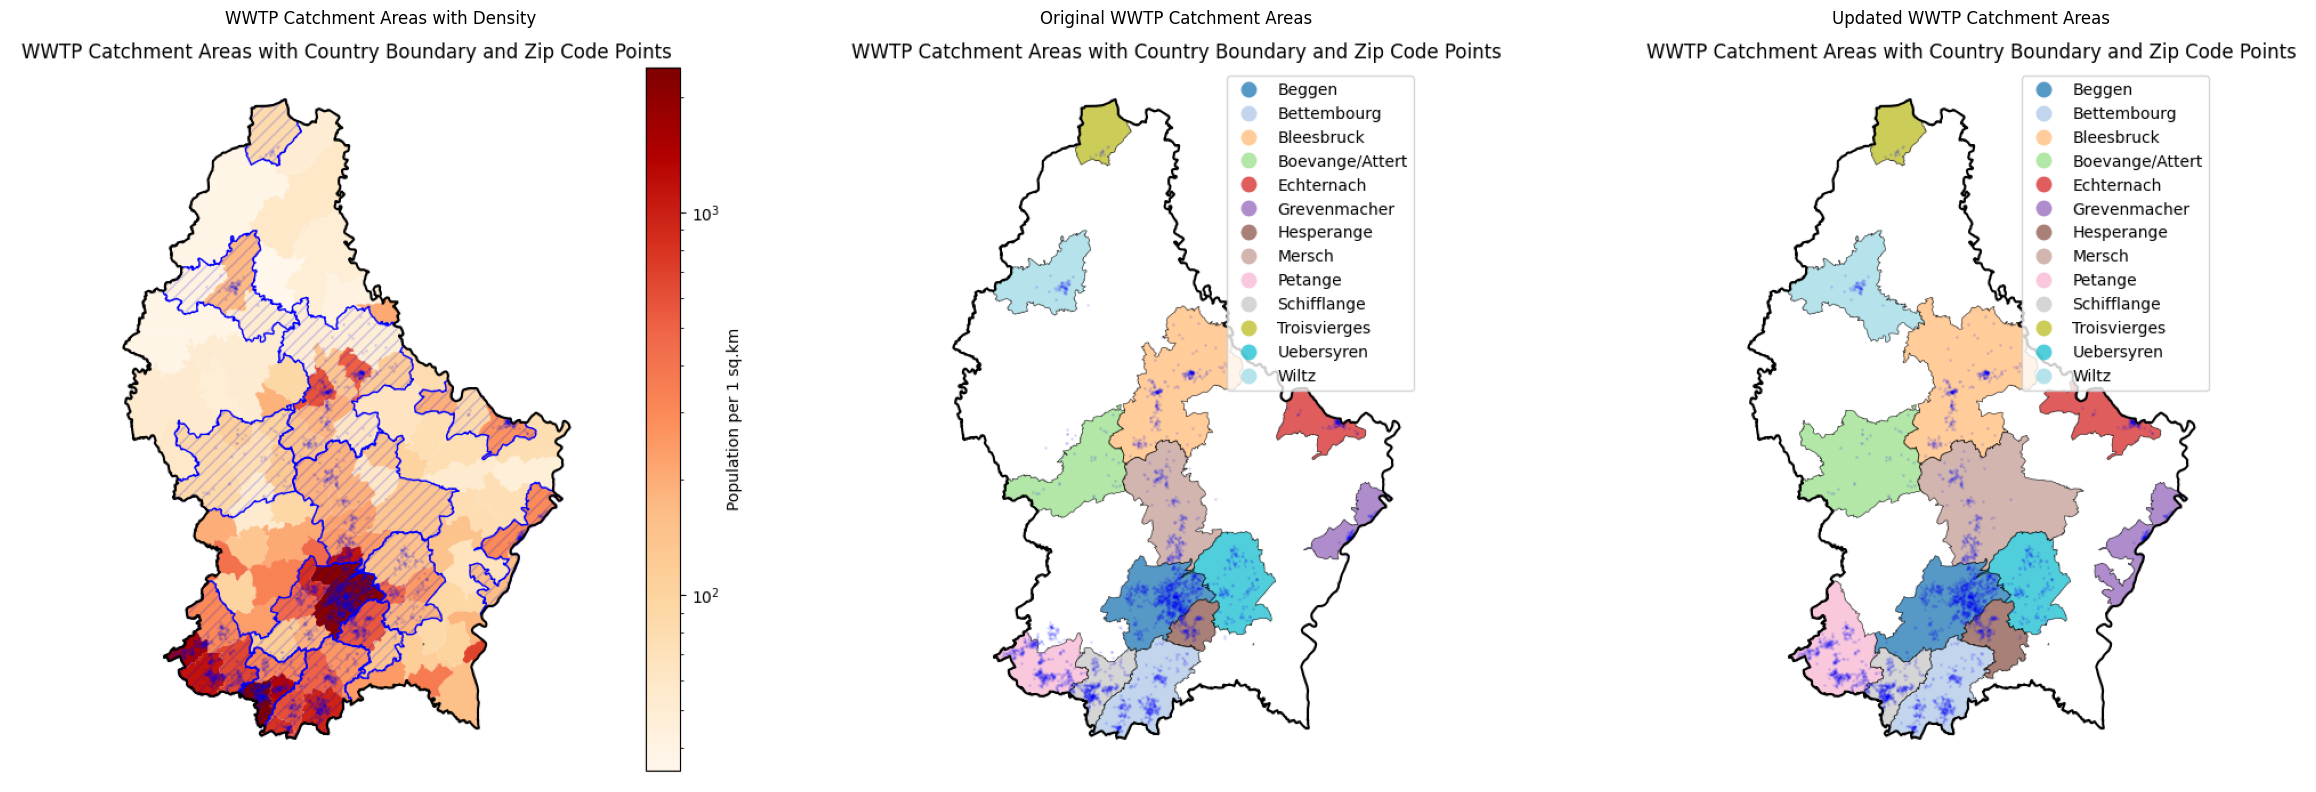

In [40]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Plot the first plot
axs[0].imshow(plot_bottom_left_w_zip_wwtp_mod_w_density.canvas.buffer_rgba())
axs[0].axis('off')
axs[0].set_title('WWTP Catchment Areas with Density')

# Plot the second plot
axs[1].imshow(plot_top_left_w_zip_wwtp_orig.canvas.buffer_rgba())
axs[1].axis('off')
axs[1].set_title('Original WWTP Catchment Areas')

# Plot the third plot
axs[2].imshow(plot_bottom_left_w_zip_wwtp_mod.canvas.buffer_rgba())
axs[2].axis('off')
axs[2].set_title('Updated WWTP Catchment Areas')

# Adjust layout
plt.tight_layout()

# Save the plot to a file
plt.savefig('./images/WWTP_catchment_areas_comapare.png', dpi=300)

# Show the combined plot
plt.show()

# plot cantons on the wwtp

In [41]:
cantons.columns

Index(['geometry', 'COMMUNE', 'DISTRICT', 'LAU2', 'CANTON'], dtype='object')

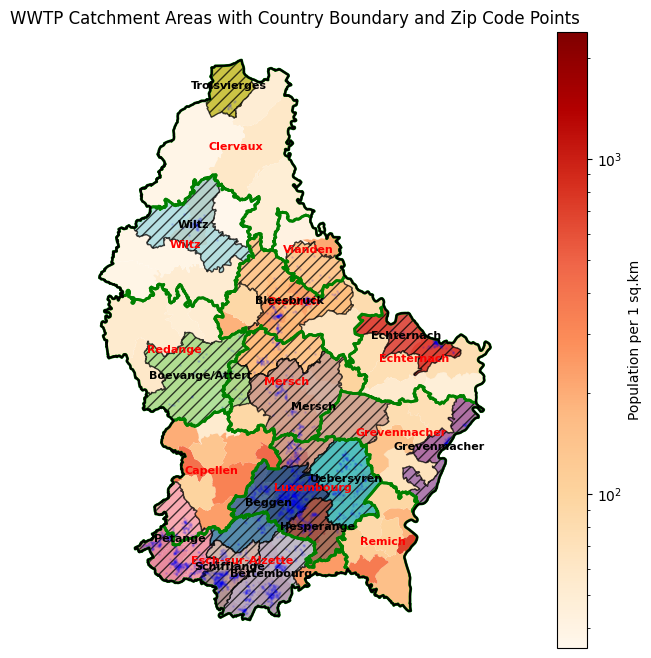

In [44]:
# Plot both
fig, ax = plt.subplots(figsize=(12, 8))

# Plot WWTP catchments in color
# dissolved.boundary.plot(ax=ax, cmap='tab20', hatch='///', color='blue', alpha=0.2, linewidth=0.1)
# dissolved.boundary.plot(ax=ax, cmap='tab20', color='blue', alpha=1, linewidth=1)

density.plot(ax=ax, column='Densité de', cmap='OrRd', alpha=1, legend=True, norm=LogNorm(), 
             legend_kwds={'label': "Population per 1 sq.km"})

cantons.boundary.plot(ax=ax, color='green', linewidth=2)
# cantons.plot(ax=ax, column='COMMUNE', linewidth=1, alpha=0.1, legend=True, edgecolor='red')

# Add labels for each Canton area
for idx, row in cantons.iterrows():
    plt.annotate(text=row['CANTON'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center', fontsize=8, color='red', weight='bold')


dissolved_mod.plot(ax=ax, column='WWTP', cmap='tab20',  hatch='///', alpha=0.75, legend=False, edgecolor='black', linewidth=1)

# Add labels for each WWTP area
for idx, row in dissolved_mod.iterrows():
    plt.annotate(text=row['WWTP'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center', fontsize=8, color='black', weight='bold')

# Overlay country boundary in bold black
country.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Plot the zip code points (from the coordinates DataFrame)
zip_points = gpd.GeoDataFrame(
    zip_coordinates_df, 
    geometry=gpd.points_from_xy(zip_coordinates_df.longitude, zip_coordinates_df.latitude),
    crs="EPSG:4326"
)

# Plot the points
zip_points.plot(ax=ax, color='blue', markersize=1, alpha=0.1, label='Zip Code Points')

# Add a legend and title
# plt.legend()
plt.title("WWTP Catchment Areas with Country Boundary and Zip Code Points")
plt.axis("off")

# Save the plot to a file
# plt.savefig('./images/WWTP_catchment_areas_modified_w_zip_cantons.png', dpi=300)

# Save the figure in a variable
plot_bottom_left_w_zip_wwtp_mod_w_cant_w_density = fig

plt.show()


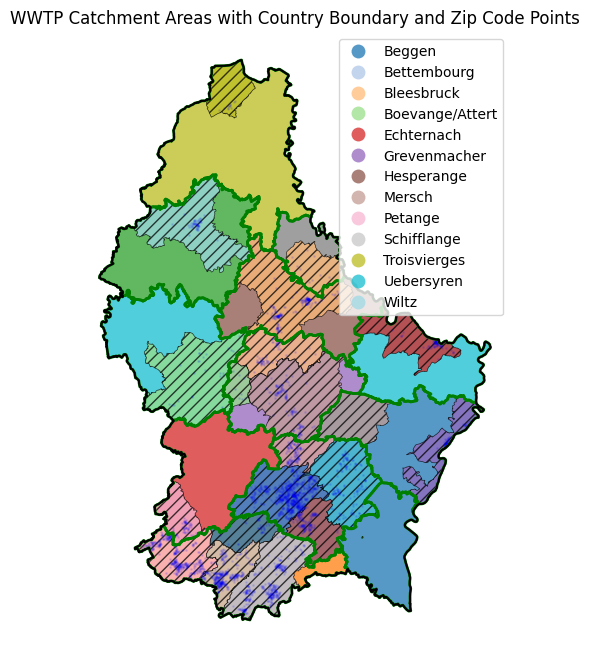

In [43]:
# Plot both
fig, ax = plt.subplots(figsize=(12, 8))

# Plot WWTP catchments in color
# dissolved.boundary.plot(ax=ax, cmap='tab20', hatch='///', color='blue', alpha=0.2, linewidth=0.1)
# dissolved.boundary.plot(ax=ax, cmap='tab20', color='blue', alpha=1, linewidth=1)

cantons.boundary.plot(ax=ax, color='green', linewidth=2)
cantons.plot(ax=ax, column='COMMUNE', linewidth=1, alpha=0.75, legend=True, edgecolor='red')

dissolved_mod.plot(ax=ax, column='WWTP', cmap='tab20',  hatch='///', alpha=0.75, legend=True, edgecolor='black', linewidth=0.5)

# Overlay country boundary in bold black
country.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Plot the zip code points (from the coordinates DataFrame)
zip_points = gpd.GeoDataFrame(
    zip_coordinates_df, 
    geometry=gpd.points_from_xy(zip_coordinates_df.longitude, zip_coordinates_df.latitude),
    crs="EPSG:4326"
)

# Plot the points
zip_points.plot(ax=ax, color='blue', markersize=1, alpha=0.1, label='Zip Code Points')

# Add a legend and title
# plt.legend()
plt.title("WWTP Catchment Areas with Country Boundary and Zip Code Points")
plt.axis("off")

# Save the plot to a file
plt.savefig('./images/WWTP_catchment_areas_modified_w_zip_cantons.png', dpi=300)

# Save the figure in a variable
plot_bottom_left_w_zip_wwtp_mod_w_cant = fig

plt.show()
